#### Causal Discovery Module Research

In [17]:
# !pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=aaa7a419e6823aa12e8a3f0bcaaaf4ab9b6f0026b498164c537dcaf0ed7b9763
  Stored in directory: c:\users\tomle\appdata\local\pip\cache\wheels\8b\f1\7f\5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [1]:
#Causal Graph Viz for slide
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown
import wget
import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
style.use("fivethirtyeight")

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

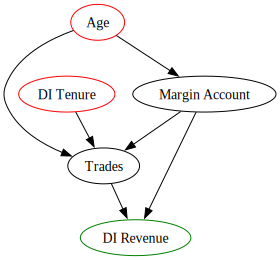

In [2]:
#DI Example
g = gr.Digraph()

g.edge("Margin Account", "Trades")
g.edge("Trades", "DI Revenue")
g.edge("Margin Account", "DI Revenue")
g.edge("Age", "Margin Account")
g.edge("Age", "Trades")
g.edge("DI Tenure", "Trades")

g.node("DI Revenue", "DI Revenue", color="green")
g.node("Age", "Age", color="red")
g.node("DI Tenure", "DI Tenure", color="red")

g

### Test Datasets

In [61]:
# 1991 Survey of Income and Program Participation (401k) - very small weight for treatment (net_tfa) from discovery
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data = pd.read_csv(file)
data.head()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,tw,age,inc,fsize,educ,db,marr,male,twoearn,dum91,e401,p401,pira,nohs,hs,smcol,col,icat,ecat,zhat,net_n401,hown,i1,i2,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
0,0,0,69000,60150,8850,100,-3300,100,-3300,5550,53550,31,28146,5,12,0,1,0,0,1,0,0,0,0,1,0,0,3,2,0.273178,-3300,1,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,78000,20000,58000,61010,61010,61010,61010,119010,124635,52,32634,5,16,0,0,0,0,1,0,0,0,0,0,0,1,4,4,0.386641,61010,1,0,0,0,1,0,0,0,0,0,0,1,0
2,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,192949,50,52206,3,11,0,1,1,1,1,0,0,1,1,0,0,0,6,1,0.533650,8849,1,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,2487,-6013,2487,-6013,-6013,-513,28,45252,4,15,0,1,0,1,1,0,0,0,0,0,1,0,5,3,0.324319,-6013,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,212087,42,33126,3,12,1,0,0,0,1,0,0,0,0,1,0,0,4,2,0.602807,-2375,1,0,0,0,1,0,0,0,0,0,1,0,0


In [62]:
# #401k dataset metadata
# # readme = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.md"
# # filename = wget.download(readme)
# Markdown(open('401k.md', 'r').read())

In [63]:
#define inputs - 401k dataset



t = 'e401'
select_data = data[data.columns[:-12]]
# select_data = data.loc[:, data.nunique() > 2]
select_data[t] = data[t]
col_names = select_data.columns

# #create input data, no cross-fitting
# input_data = select_data.to_numpy(np.float64)
# input_data.shape

#create input data, cross-fitting (2-fold)
split1, split2 = train_test_split(select_data, test_size=0.5, random_state=2025, stratify=select_data[t])
X1, X2 = split1.to_numpy(), split2.to_numpy()
X1.shape, X2.shape
split1[t].value_counts(), split2[t].value_counts()

(e401
 0    3116
 1    1841
 Name: count, dtype: int64,
 e401
 0    3117
 1    1841
 Name: count, dtype: int64)

In [34]:
# # Software Usage Promotion Campaign Uplift Modeling
# file = "datasets/multi_attribution_sample.csv"
# data = pd.read_csv(file, encoding='utf-8')
# data.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


In [35]:
# # Software Usage Promotion Campaign Uplift Modeling metadata
# """
# name	type	description
# Global Flag	W	whether the customer has global offices
# Major Flag	W	whether the customer is a large consumer in their industry (as opposed to SMC - Small Medium Corporation - or
# SMC Flag	W	whether the customer is a Small Medium Corporation (SMC, as opposed to major and SMB)
# Commercial Flag	W	whether the customer's business is commercial (as opposed to public secor)
# IT Spend	W	$ spent on IT-related purchases
# Employee Count	W	number of employees
# PC Count	W	number of PCs used by the customer
# Size	X	customer's size given by their yearly total revenue
# Tech Support	T	whether the customer received tech support (binary)
# Discount	T	whether the customer was given a discount (binary)
# Revenue	Y	$ Revenue from customer given by the amount of software purchased

# """

"\nname\ttype\tdescription\nGlobal Flag\tW\twhether the customer has global offices\nMajor Flag\tW\twhether the customer is a large consumer in their industry (as opposed to SMC - Small Medium Corporation - or\nSMC Flag\tW\twhether the customer is a Small Medium Corporation (SMC, as opposed to major and SMB)\nCommercial Flag\tW\twhether the customer's business is commercial (as opposed to public secor)\nIT Spend\tW\t$ spent on IT-related purchases\nEmployee Count\tW\tnumber of employees\nPC Count\tW\tnumber of PCs used by the customer\nSize\tX\tcustomer's size given by their yearly total revenue\nTech Support\tT\twhether the customer received tech support (binary)\nDiscount\tT\twhether the customer was given a discount (binary)\nRevenue\tY\t$ Revenue from customer given by the amount of software purchased\n\n"

In [39]:
# #define inputs - Software dataset

# t='Discount'
# select_data = data
# col_names = select_data.columns

# # #create input data, no cross-fitting
# # input_data = select_data.to_numpy()
# # input_data.shape

# #create input data, cross-fitting (2-fold)
# split1, split2 = train_test_split(select_data, test_size=0.5, random_state=2025, stratify=select_data[t])
# X1, X2 = split1.to_numpy(), split2.to_numpy()
# X1.shape, X2.shape
# split1[t].value_counts(), split2[t].value_counts()

(Discount
 1    510
 0    490
 Name: count, dtype: int64,
 Discount
 1    511
 0    489
 Name: count, dtype: int64)

In [58]:
# #Bank Churn dataset
# file = "datasets/churn.csv"
# data = pd.read_csv(file, encoding='utf-8', index_col=0)
# data.head()

In [59]:
# #define inputs - Churn dataset

# cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
# # select_data = data[cols]
# select_data = pd.get_dummies(data[[cols for cols in data.columns if cols not in ['RowNumber', 'CustomerId', 'Surname']]], dtype='int')
# col_names = select_data.columns


# #create input data, no cross-fitting
# input_data = select_data.to_numpy()

# #create input data, cross-fitting (2-fold)
# split1, split2 = train_test_split(select_data, test_size=0.5, random_state=2025)
# X1, X2 = split1.to_numpy(), split2.to_numpy()
# X1.shape, X2.shape

In [46]:
select_data.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [60]:
#load learned DAG
W_avg = np.loadtxt('learned_dag_401k_dagma_NL.txt', dtype=np.float64)

### Discovery module testing

In [30]:
#this module will contain the main classes for causal discovery and DAG visualization

import pandas as pd
import numpy as np
import torch
from dagma import utils
# from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear
from dagma.linear import DagmaLinear
import graphviz as gr

class NonLinear_CausalDiscovery():

    """
    Main class for causal discovery (Non-linear). Instances of this class will learn a DAG from input data using a specified method. Instantiating this class will automatically learn a DAG from the input data using the provided method.

    Linear class to be added later.

    Parameters
    ----------
    data : np.ndarray
        The input data containing X, T and Y as a NumPy array.
    method: str, optional
        Method used for causal discovery. Currently only supports the default algorithm ("dagma")
    col_names: list
        List of column names for the input data.
    mlp_dims: list
        Dimensions of the MLP used for structural equations. Default is [d, int(d/2), 1] where d is the number of columns in the input data.
    """


    def __init__(self, data: np.ndarray, col_names=None ,method: str='dagma', dag=None, pruned_dag=None, mlp_dims=None):
        self.data = data
        self.col_names = col_names
        if mlp_dims is None:
            self.mlp_dims = [self.data.shape[1], int(self.data.shape[1]/2), 1]
        else:
            self.mlp_dims=mlp_dims
        self.method = method
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self._validate_data()
        self.dag = self.learn_dag()
        self.pruned_dag = None

    def _validate_data(self):
        if not isinstance(self.data, np.ndarray):
            raise ValueError('Input data must be a NumPy ndarray.')
        if not np.issubdtype(self.data.dtype, np.number):
            raise ValueError('Input data must be numeric.')
        if self.col_names is None:
            raise ValueError('List of column names not provided.')
        if len(self.col_names) != self.data.shape[1]:
            raise ValueError('Number of column names does not match number of columns in data.')

    def learn_dag(self):
        if self.method == 'dagma':
            # define MLP for structural equations with given dimensions(default [d, int(d/2), 1]) and associated model
            d = self.data.shape[1]
            eq_model = DagmaMLP(dims=self.mlp_dims, bias=True, dtype=torch.double).to(self.device)
            model = DagmaNonlinear(eq_model, dtype=torch.double)

            #Move data to GPU if available, otherwise use CPU
            data_tensor = torch.tensor(self.data, dtype=torch.double).to(self.device)

            # fit the model with default L1 and L2 regularization and no default minimum weight threshold
            W_est = model.fit(data_tensor, lambda1=0, lambda2=0, w_threshold=0)
            return W_est  # Move the result back to CPU and convert to NumPy array
        else:
            raise ValueError('Invalid method. Currently only supports "dagma".')
        
    def prune_dag(self, prune_method='percent', prune_threshold=0.02):
        if prune_method == 'percent':
            pruned_dag = np.where(self.dag <= self.dag.sum()*prune_threshold, 0, self.dag)
        if prune_method == 'absolute':
            pruned_dag = np.where(self.dag <= prune_threshold, 0, self.dag)
        return pruned_dag
    
    def display_dag(self, prune_method='percent', prune_threshold=0.02, return_pruned_W=False):
        if prune_method in ['percent', 'absolute']:
            adj_matrix = self.prune_dag(prune_method=prune_method, prune_threshold=prune_threshold)
        else:
            raise ValueError('Invalid pruning method. Supports either "percent" or "absolute".')

        dot = gr.Digraph()
        for name in self.col_names:
            dot.node(name)

        for i in range(adj_matrix.shape[0]):
            for j in range(adj_matrix.shape[1]):
                if adj_matrix[i,j] != 0:
                    weight = adj_matrix[i, j]
                    dot.edge(self.col_names[i], self.col_names[j], label=f'{weight:.3f}')

        if return_pruned_W:
            self.pruned_dag = adj_matrix
            return dot
        else:
            return dot

class Linear_CausalDiscovery():

    """
    Main class for causal discovery (Linear). Instances of this class will learn a DAG from input data using a specified method. Instantiating this class will automatically learn a DAG from the input data using the provided method.

    Parameters
    ----------
    data : np.ndarray
        The input data containing X, T and Y as a NumPy array.
    method: str, optional
        Method used for causal discovery. Currently only supports the default algorithm ("dagma")
    col_names: list
        List of column names for the input data.
    """

    def __init__(self, data: np.ndarray, col_names=None ,method: str='dagma', loss_type='l2', dag=None, pruned_dag=None):
        self.data = data
        self.col_names = col_names
        self.method = method
        self.loss_type = loss_type
        self._validate_data()
        self.dag = self.learn_dag()
        self.pruned_dag = None 

    def _validate_data(self):
        if not isinstance(self.data, np.ndarray):
            raise ValueError('Input data must be a NumPy ndarray.')
        if not np.issubdtype(self.data.dtype, np.number):
            raise ValueError('Input data must be numeric.')
        if self.col_names is None:
            raise ValueError('List of column names not provided.')
        if len(self.col_names) != self.data.shape[1]:
            raise ValueError('Number of column names does not match number of columns in data.')
    
    def learn_dag(self):
        if self.method == 'dagma':
            # Define linear model for structural equations
            model = DagmaLinear(loss_type=self.loss_type)
            W_est = model.fit(self.data, lambda1=0, w_threshold=0)
            return W_est  # Move the result back to CPU and convert to NumPy array
        else:
            raise ValueError('Invalid method. Currently only supports "dagma".')
    
    def prune_dag(self, prune_method='percent', prune_threshold=0.02):
        if prune_method == 'percent':
            pruned_dag = np.where(self.dag <= self.dag.sum()*prune_threshold, 0, self.dag)
        if prune_method == 'absolute':
            pruned_dag = np.where(self.dag <= prune_threshold, 0, self.dag)
        return pruned_dag
    
    def display_dag(self, prune_method='percent', prune_threshold=0.02, return_pruned_W=False):
        if prune_method in ['percent', 'absolute']:
            adj_matrix = self.prune_dag(prune_method=prune_method, prune_threshold=prune_threshold)
        else:
            raise ValueError('Invalid pruning method. Supports either "percent" or "absolute".')

        dot = gr.Digraph()

        for name in self.col_names:
            dot.node(name)

        for i in range(adj_matrix.shape[0]):
            for j in range(adj_matrix.shape[1]):
                if adj_matrix[i,j] != 0:
                    weight = adj_matrix[i, j]
                    dot.edge(self.col_names[i], self.col_names[j], label=f'{weight:.3f}')

        if return_pruned_W:
            self.pruned_dag = adj_matrix
            return dot
        else:
            return dot

def manual_display_dag(W, col_names):

    """
    Helper function for manually displaying a DAG. This function takes an adjacency matrix and column names as input and returns a graphviz object for visualization. One intended use is for displaying sample-split-and-averaged (cross-fitted) DAGs.

    Parameters
    ----------

    W : np.ndarray
        Adjacency matrix (i,j) representing the DAG, where W[i,j] is the weight of the edge from node i to node j.
    
    col_names : list
        List of column names for the input data.
    """

    dot = gr.Digraph(engine='dot')

    for name in col_names:
        dot.node(name)

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if W[i,j] != 0:
                weight = W[i, j]
                dot.edge(col_names[i], col_names[j], label=f'{weight:.3f}')

    return dot
    

### Non-Linear Test

In [53]:
# #instantiate NonLinear_CausalDiscovery - no cross-fitting
# torch.cuda.manual_seed(2025)
# dagma_401k = NonLinear_CausalDiscovery(input_data, col_names=col_names)

100%|██████████| 230000/230000.0 [00:15<00:00, 14971.05it/s]


Is pruned graph a DAG (i.e. acyclic)? True


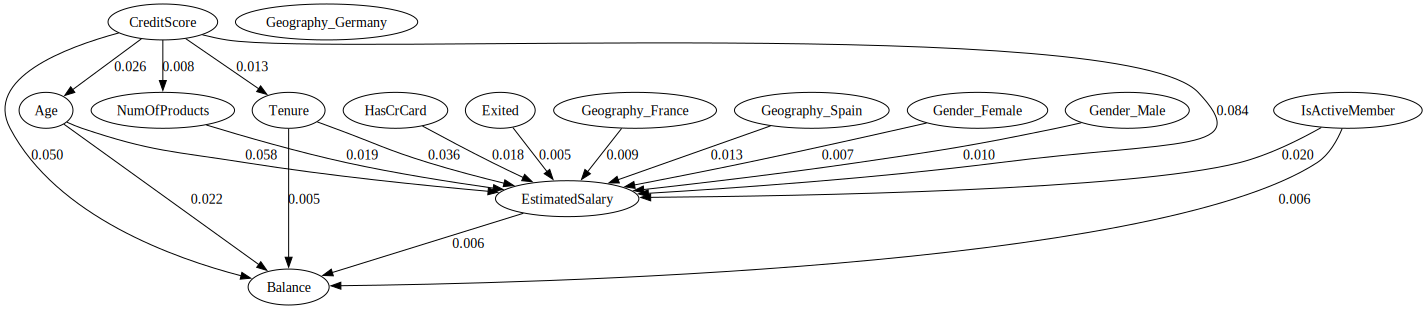

In [ ]:
# #display DAG - no cross-fitting
# dot = dagma_401k.display_dag(prune_method='percent', prune_threshold=0.01,return_pruned_W=True)
# print('Is pruned graph a DAG (i.e. acyclic)?', utils.is_dag(dagma_401k.pruned_dag))
# dot

In [ ]:
#instantiate 2 instances NonLinear_CausalDiscovery - cross-fitting
torch.cuda.manual_seed(2025)
dagma_401k_a = NonLinear_CausalDiscovery(X1, col_names=col_names)
dagma_401k_b = NonLinear_CausalDiscovery(X2, col_names=col_names)

In [ ]:
#display DAG - cross-fitting

#prune and display both DAGs, starting with a
dot = dagma_401k_a.display_dag(prune_method='percent', prune_threshold=0.01, return_pruned_W=True)
print('Is pruned graph a DAG (i.e. acyclic)?', utils.is_dag(dagma_401k_a.pruned_dag))
dot

Is pruned graph a DAG (i.e. acyclic)? True


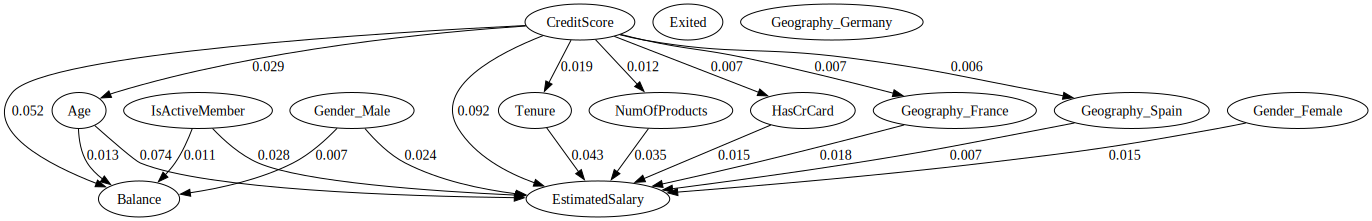

In [49]:
#b
dot = dagma_401k_b.display_dag(prune_method='percent', prune_threshold=0.01,return_pruned_W=True)
print('Is pruned graph a DAG (i.e. acyclic)?', utils.is_dag(dagma_401k_b.pruned_dag))
dot

Is pruned graph a DAG (i.e. acyclic)? True


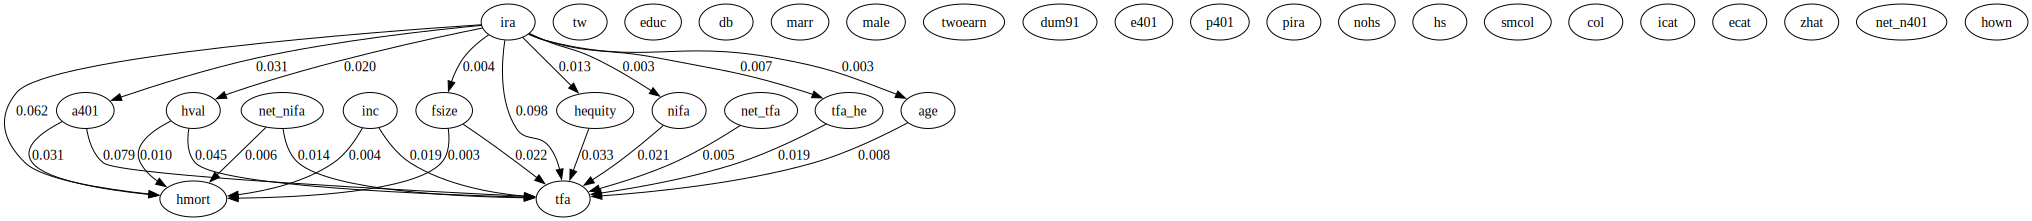

In [64]:
#display average of both DAGs
W_avg = (dagma_401k_a.pruned_dag + dagma_401k_b.pruned_dag)/2
print('Is pruned graph a DAG (i.e. acyclic)?', utils.is_dag(W_avg))
dot = manual_display_dag(W_avg, col_names)
dot

In [57]:
dagma_401k_a.pruned_dag.sum(), dagma_401k_b.pruned_dag.sum(), W_avg.sum()

(0.6084940986714096, 0.5154245445546315, 0.5619593216130205)

In [9]:
W_avg.sum()

4.85449

In [43]:
#save learned DAG
np.savetxt('learned_dag_401k_dagma_NL.txt', W_avg, fmt='%1.6f')

### Linear Test

In [21]:
#instantiate Linear_CausalDiscovery - no cross-fitting
dagma_401k = Linear_CausalDiscovery(input_data, col_names=col_names)

100%|██████████| 180000/180000.0 [00:09<00:00, 18695.98it/s]


Is pruned graph a DAG (i.e. acyclic)? False


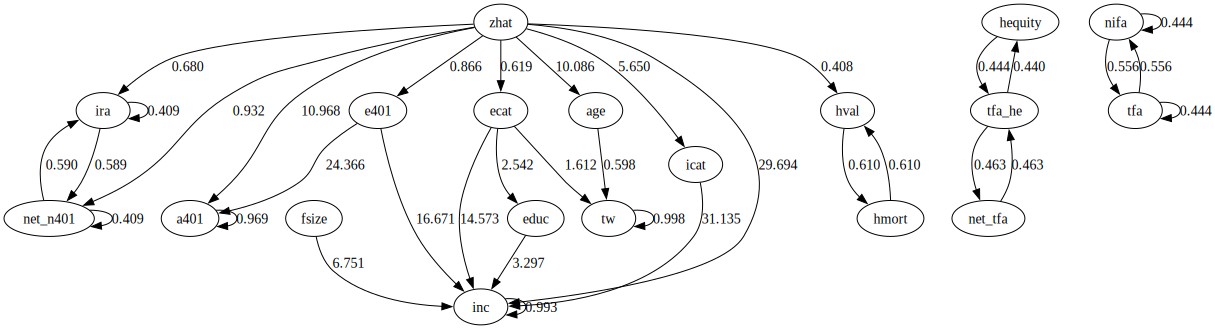

In [24]:
#display DAG - no cross-fitting
dot = dagma_401k.display_dag(prune_method='absolute', prune_threshold=0.4,return_pruned_W=True)
print('Is pruned graph a DAG (i.e. acyclic)?', utils.is_dag(dagma_401k.pruned_dag))
dot

In [15]:
dagma_401k.pruned_dag.sum()

45.82980773911348